In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

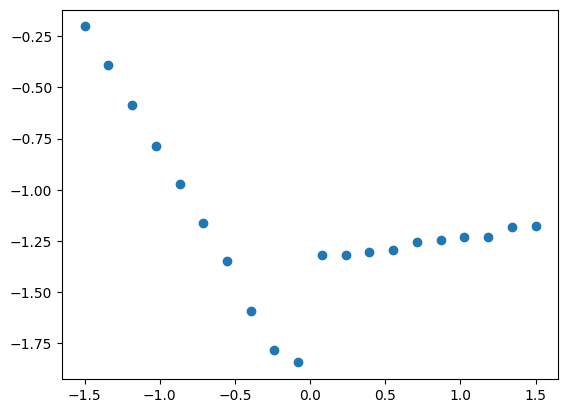

In [6]:
data = np.genfromtxt("current_save.csv")
vs = np.linspace(-1.5, 1.5, len(data))
plt.scatter(vs, data)

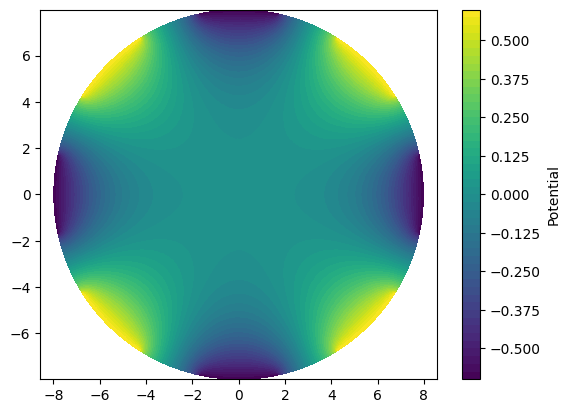

In [3]:
df = pd.read_csv("my_potential.csv")
plt.tricontourf(df.x, df.y, df.potential, levels=50)
plt.colorbar(label="Potential")
plt.axis("equal")
plt.show()


(300, 8)
(300,)


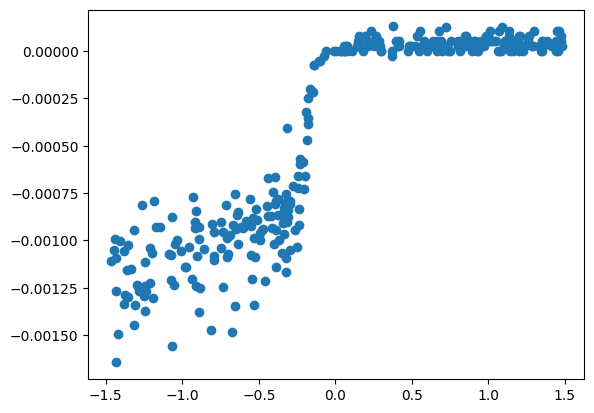

In [4]:
batch = np.load("currentData/batch_test.npz")
print(batch["inputs"].shape)
print(batch["outputs"].shape)

plt.scatter(batch["inputs"][:,1], batch["outputs"])